In [173]:
#Importing the modules
import os
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib as mpl

import matplotlib.dates as mdates
import matplotlib.pyplot as plt

import seaborn as sns

# recommended by Pandas
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import glob
from glob import glob

import datetime

from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler

# Change to the correct directory
os.chdir('/Users/BawBawBaw/Desktop/Extension School/Applied Datascience Machine learning/05-Capstone Project/Data/GVA/GVA_data')

# TO BE USED FOR TRAINING PURPOSE ONLY
%store -r data_ofac_cleaned


# importing the cost functions from Scikit learn

# MAE - mean absolute error
from sklearn.metrics import mean_absolute_error

# MSE - mean squared error
from sklearn.metrics import mean_squared_error

# MSLE
from sklearn.metrics import mean_squared_log_error

# R2
from sklearn.metrics import r2_score

from math import sqrt

def shiftingvalues(df, iata_code, nbshift):

# ADD DESCRIPTION

    i = np.arange(1, nbshift+1, 1)
    for nb in i:
        df['x'+iata_code+str(nb)] = df[iata_code].shift(nb)
    return df.head(10)

"""Function to transform values to log nth difference
It takes a numpy array and take the log difference. We can specify the shift with the variable n.
Source : # https://groups.google.com/forum/#!topic/pystatsmodels/rdyNYlxJyg8 -> for the
np.diff(np.log. The function has been written by me
"""

def transdiff(source, n):
    
    c = np.diff(np.log(source), n=n)
    return c

"""Function to reverse transform values from log n-difference, and converts the data type to integer.
Source : # https://groups.google.com/forum/#!topic/pystatsmodels/rdyNYlxJyg8 -> for the
np.exp(np.cumsum(np.concatenate(([np.log(orig[0])], logdiff)))). The function has bee
written by me
"""

def revtransdiff(logdiff, orig): 
    d = np.exp(np.cumsum(np.concatenate(([np.log(orig[0])], logdiff))))
    d = d.astype(int)
    return d

data_ofac_cleaned['y_GVA'] = data_ofac_cleaned['GVA']

# using the function
shiftingvalues(data_ofac_cleaned, 'GVA', 31) 


def createsetsmultifeaturesMSadd1(df, iata_code, nbshift, lg1, adcol):

# ADD DESCRIPTION

# defining the real values

    # defining x_real dataset
    nbshiftserie = len(np.arange(0, nbshift, 7)[1:])  # defines the # of times we find a multiple of 7
    nbturn = np.arange(1, nbshiftserie+1, 1)  # defines the # of loop to execute
    nbincr = len(np.arange(1, len(np.arange(0, nbshift, 7)[1:])+1, 1))*7  # defines the # of days to shift
    
    print('# multiples of 7 : {}'.format(nbshiftserie))
    print('# loops to execute : {}'.format(nbturn))
    print('# of days to shift : {}'.format(nbincr))
    
    x_real = pd.DataFrame()
    x_logdiff = pd.DataFrame()

    for col in df[adcol].columns:
        x_real[col] = (df.loc[datetime.date(year=1984, month=1, day=2+nbincr):datetime.date(year=2019, month=12, day=31)][col])
        x_logdiff[col] = x_real[col].loc[datetime.date(year=1984, month=1, day=2+nbincr+1):datetime.date(year=2019, month=12, day=31)]
            #one more day is added as the logdiff doesn't take into account the first day        

    if lg1 == 'y':
        x_real[1] = (df.loc[datetime.date(year=1984, month=1, day=2+nbincr):datetime.date(year=2019, month=12, day=31)]['x'+iata_code+str(1)])
        x_logdiff[1] = np.diff(np.log(x_real[1]))            
            
    for i in nbturn:
        lag = i * 7
        x_real[lag] = (df.loc[datetime.date(year=1984, month=1, day=2+nbincr):datetime.date(year=2019, month=12, day=31)]['x'+iata_code+str(lag)])
        x_logdiff[lag] = np.diff(np.log(x_real[lag]))        
            
        
    print(x_real.head(5))
    
    x_real = np.column_stack([x_real])  # stacking the columns to be interpreted with Scikit learn
    x_logdiff = np.column_stack([x_logdiff])
    
    # defining y_real dataset
    y_real = df.loc[datetime.date(year=1984, month=1, day=2+nbincr):datetime.date(year=2019, month=12, day=31)]['y_'+iata_code]

# defining the log diff values

    #x_logdiff = np.diff(np.log(x_real))
    y_logdiff = np.diff(np.log(y_real))
    
    # defining the separation line for the train/test set
    uptoline = int(len(x_real)*0.7609191903819814)   #0.70075
    print('Line nb of train/test sets : {}'.format(uptoline))
    
# defining the log diff values for the train set
    x_train_logdiff = x_logdiff[:uptoline-1]
    y_train_logdiff = y_logdiff[:uptoline-1]

# defining the log diff values for the test set
    x_test_logdiff = x_logdiff[uptoline:]
    y_test_logdiff = y_logdiff[uptoline:]

# defining the real values for the train set
    x_train_real = x_real[:uptoline]
    y_train_real = y_real[:uptoline]

# defining the real values for the test set
    x_test_real = x_real[uptoline:]
    y_test_real = y_real[uptoline:]
    
    return (x_logdiff, y_logdiff,
            x_real, y_real,
            x_train_logdiff, y_train_logdiff,
           x_test_logdiff, y_test_logdiff,
           x_train_real, y_train_real,
            x_test_real, y_test_real
           )

def createsetsmultifeatures(df, iata_code, nbshift):

# ADD DESCRIPTION

# defining the real values

    # defining x_real dataset
    nbshiftserie = np.arange(1, nbshift+1, 1)
    
    x_real = pd.DataFrame()
    x_logdiff = pd.DataFrame()
    
    for i in nbshiftserie:
        x_real[i] = (data_ofac_cleaned.loc[datetime.date(year=1984, month=1, day=1+nbshift):datetime.date(year=2019, month=12, day=31)]['x'+iata_code+str(i)])
        x_logdiff[i] = np.diff(np.log(x_real[i]))
    
    x_real = np.column_stack([x_real])  # stacking the columns to be interpreted with Scikit learn
    x_logdiff = np.column_stack([x_logdiff])
    
    # defining y_real dataset
    y_real = data_ofac_cleaned.loc[datetime.date(year=1984, month=1, day=1+nbshift):datetime.date(year=2019, month=12, day=31)]['y_'+iata_code]

# defining the log diff values

    #x_logdiff = np.diff(np.log(x_real))
    y_logdiff = np.diff(np.log(y_real))
    
    # defining the separation line for the train/test set
    uptoline = int(len(x_real)*0.70075)
    #print(uptoline)
    
# defining the log diff values for the train set
    x_train_logdiff = x_logdiff[:uptoline-1]
    y_train_logdiff = y_logdiff[:uptoline-1]

# defining the log diff values for the test set
    x_test_logdiff = x_logdiff[uptoline:]
    y_test_logdiff = y_logdiff[uptoline:]

# defining the real values for the train set
    x_train_real = x_real[:uptoline]
    y_train_real = y_real[:uptoline]

# defining the real values for the test set
    x_test_real = x_real[uptoline:]
    y_test_real = y_real[uptoline:]
    
    return (x_logdiff, y_logdiff,
            x_real, y_real,
            x_train_logdiff, y_train_logdiff,
           x_test_logdiff, y_test_logdiff,
           x_train_real, y_train_real,
            x_test_real, y_test_real
           )


from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

data_ofac_cleaned['month_nb'] = data_ofac_cleaned['month_nb'].astype('int64')

# KNN REGRESSOR



## 1. Using 2 basic features - month & year

### 1.1 Using true values

R2 -1.2668518977512


/Applications/anaconda3/envs/exts-ml_NEW/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Applications/anaconda3/envs/exts-ml_NEW/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Applications/anaconda3/envs/exts-ml_NEW/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Applications/anaconda3/envs/exts-ml_NEW/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


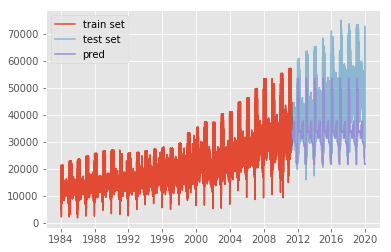

In [174]:
# 1.1 KNN - real data scaled
# preparing the datasets
x_gva_simple = data_ofac_cleaned[['year', 'month_nb']].loc['1984-01-02':]
x_gva_simple_train = x_gva_simple.iloc[:10000].values
x_gva_simple_test = x_gva_simple.iloc[10000:].values

y_gva_simple = data_ofac_cleaned['y_GVA'].loc['1984-01-02':]
y_gva_simple_train = y_gva_simple.iloc[:10000].values
y_gva_simple_test = y_gva_simple.iloc[10000:].values

knn_pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('knn', KNeighborsRegressor(n_neighbors=2))
        ])

knn_pipe.fit(x_gva_simple_train, y_gva_simple_train)

y_gva_simple_pred = knn_pipe.predict(x_gva_simple_test)
print('R2 {}'.format(knn_pipe.score(x_gva_simple_test, y_gva_simple_test)))

plt.plot(x_gva_simple.loc['1984-01-02':].iloc[:10000].index, y_gva_simple_train, label='train set')
plt.plot(x_gva_simple.loc['1984-01-02':].iloc[10000:].index, y_gva_simple_test, alpha=0.5, label='test set')
plt.plot(x_gva_simple.loc['1984-01-02':].iloc[10000:].index, y_gva_simple_pred, label='pred')
plt.legend()
plt.show()

### 1.2 Using LOG values

R2 -20.338363443429884


/Applications/anaconda3/envs/exts-ml_NEW/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Applications/anaconda3/envs/exts-ml_NEW/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Applications/anaconda3/envs/exts-ml_NEW/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Applications/anaconda3/envs/exts-ml_NEW/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


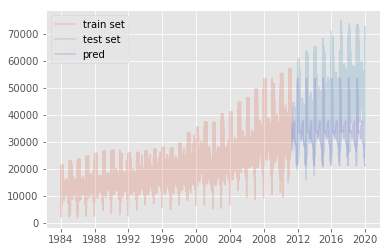

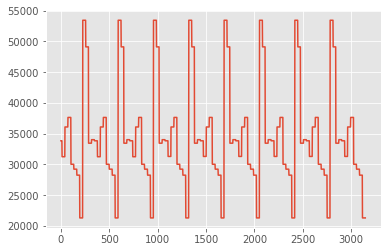

In [175]:
# 1.2 KNN - scaled TRY TO USE THE LOG OF THE DATA

#def revtransdiff(logdiff, orig): 
#    d = np.exp(np.cumsum(np.concatenate(([np.log(orig[0])], logdiff))))
#    d = d.astype(int)
#    return d

# preparing the datasets
x_gva_simple = data_ofac_cleaned[['year', 'month_nb']].loc['1984-01-02':]
x_gva_simple_train = x_gva_simple.iloc[:10000].values
x_gva_simple_test = x_gva_simple.iloc[10000:].values

y_gva_simple = data_ofac_cleaned['y_GVA'].loc['1984-01-02':]
y_gva_simple_train = y_gva_simple.iloc[:10000].values
y_gva_simple_test = y_gva_simple.iloc[10000:].values

y_gva_simple_train_diff = np.log(y_gva_simple_train)
y_gva_simple_test_diff = np.log(y_gva_simple_test)


knn_pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('knn', KNeighborsRegressor(n_neighbors=2))
        ])

knn_pipe.fit(x_gva_simple_train, y_gva_simple_train_diff)

y_gva_simple_pred = knn_pipe.predict(x_gva_simple_test[1:])
y_gva_simple_pred_tr = np.exp(y_gva_simple_pred)
print('R2 {}'.format(knn_pipe.score(x_gva_simple_test, y_gva_simple_test)))

plt.plot(x_gva_simple.loc['1984-01-02':].iloc[:10000].index, y_gva_simple_train, alpha=0.2, label='train set')
plt.plot(x_gva_simple.loc['1984-01-02':].iloc[10000:].index, y_gva_simple_test, alpha=0.2, label='test set')
plt.plot(x_gva_simple.loc['1984-01-02':].iloc[10001:].index, y_gva_simple_pred_tr, alpha=0.4, label='pred')
plt.legend()
plt.show()

plt.plot(y_gva_simple_pred_tr)

### 1.3 LOG Differiencing - y only

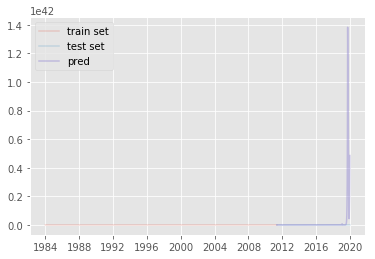

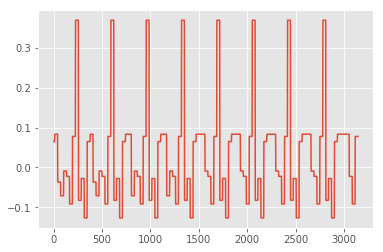

In [176]:
# 1.3 KNN - and diff only y
# preparing the datasets
x_gva_simple = data_ofac_cleaned[['year', 'month_nb']].loc['1984-01-02':]
x_gva_simple_train = x_gva_simple.iloc[:10000].values
x_gva_simple_test = x_gva_simple.iloc[10000:].values

y_gva_simple = data_ofac_cleaned['y_GVA'].loc['1984-01-02':]
y_gva_simple_train = y_gva_simple.iloc[:10000].values
y_gva_simple_test = y_gva_simple.iloc[10000:].values

y_gva_simple_train_diff = np.diff(np.log(y_gva_simple_train))
y_gva_simple_test_diff = np.diff(np.log(y_gva_simple_test))

knn = KNeighborsRegressor(n_neighbors=2)
knn.fit(x_gva_simple_train[1:], y_gva_simple_train_diff)

y_gva_simple_pred = knn.predict(x_gva_simple_test[1:])
#y_gva_simple_pred_tr = np.concatenate(([y_gva_simple_test[0]], y_gva_simple_pred)).cumsum()
y_gva_simple_pred_tr = np.exp(np.cumsum(np.concatenate(([np.log(y_gva_simple_test[0])], y_gva_simple_pred))))

plt.plot(x_gva_simple.loc['1984-01-02':].iloc[:10000].index, y_gva_simple_train, alpha=0.2, label='train set')
plt.plot(x_gva_simple.loc['1984-01-02':].iloc[10000:].index, y_gva_simple_test, alpha=0.2, label='test set')
plt.plot(x_gva_simple.loc['1984-01-02':].iloc[10000:].index, y_gva_simple_pred_tr, alpha=0.5, label='pred')
plt.legend()
plt.show()

plt.plot()
plt.plot(y_gva_simple_pred)
plt.show()



## 2. Using the continuous days as features

In [177]:
x_logdiff, y_logdiff, x_real, y_real, x_train_logdiff, y_train_logdiff, x_test_logdiff, y_test_logdiff, x_train_real, y_train_real, x_test_real, y_test_real = createsetsmultifeatures(data_ofac_cleaned, 'GVA', 7)

## 2.1 LOG DIFF values (x&y)

Accuracy logdiff X&Y: 0.642


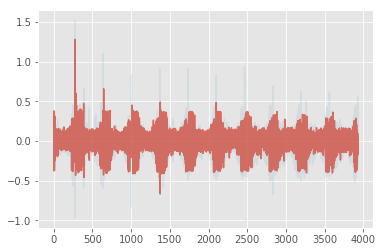

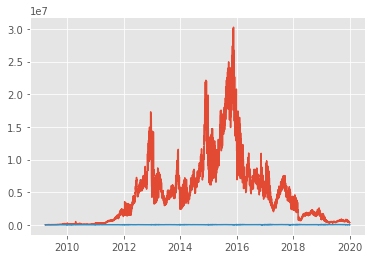

In [178]:
#2.1 LOG DIFF

from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Create a k-NN pipeline
knn_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor(n_neighbors=5))
])

# Fit estimator
knn_pipe.fit(x_train_logdiff, y_train_logdiff)

# Evaluate on test set
print('Accuracy logdiff X&Y: {:.3f}'.format(knn_pipe.score(x_test_logdiff, y_test_logdiff)))

pred = knn_pipe.predict(x_test_logdiff)
plt.plot(pred, alpha=0.8)
plt.plot(y_test_logdiff, alpha=0.1)
plt.show()

a = revtransdiff(pred, y_test_real)
plt.plot(y_test_real.index, a)
plt.plot(y_test_real.index, y_test_real)
plt.show()

### 2.2 LOG DIFF VALUES y only

Accuracy real VS logdiff: 0.423


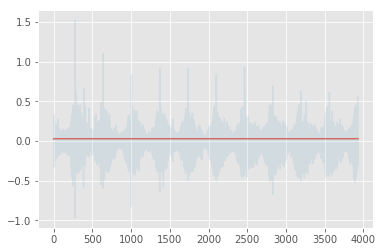

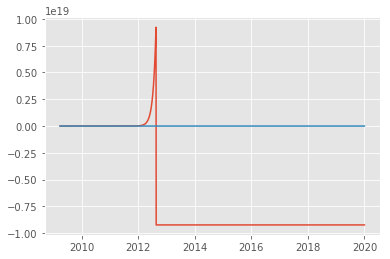

In [179]:
knn_pipe.fit(x_train_real[1:], y_train_logdiff)

# Evaluate on test set
print('Accuracy real VS logdiff: {:.3f}'.format(knn_pipe.score(x_test_real[1:], y_test_logdiff)))

pred = knn_pipe.predict(x_test_logdiff)
plt.plot(pred, alpha=0.8)
plt.plot(y_test_logdiff, alpha=0.1)
plt.show()

a = revtransdiff(pred, y_test_real)
plt.plot(y_test_real.index, a)
plt.plot(y_test_real.index, y_test_real)
plt.show()

## 2.3 Maximum accuracy obtained with 7 days lag

In [180]:
knn_pipe.fit(x_train_logdiff, y_train_logdiff)

# Evaluate on test set
print('R2 : {:.3f}'.format(knn_pipe.score(x_test_logdiff, y_test_logdiff)))

R2 : 0.642


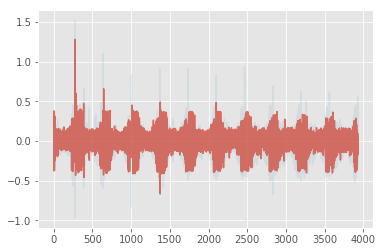

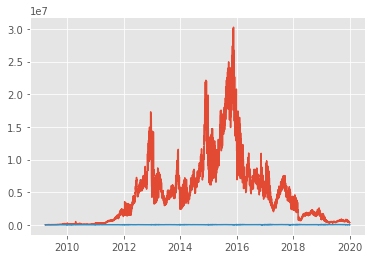

In [181]:
pred = knn_pipe.predict(x_test_logdiff)
plt.plot(pred, alpha=0.8)
plt.plot(y_test_logdiff, alpha=0.1)
plt.show()

a = revtransdiff(pred, y_test_real)
plt.plot(y_test_real.index, a)
plt.plot(y_test_real.index, y_test_real)
plt.show()

# 3. Using non-continuous day lags

In [182]:
features_col = []
x_logdiff, y_logdiff, x_real, y_real, x_train_logdiff, y_train_logdiff, x_test_logdiff, y_test_logdiff, x_train_real, y_train_real, x_test_real, y_test_real = createsetsmultifeaturesMSadd1(data_ofac_cleaned, 'GVA', 8, lg1='n', adcol=features_col)

# multiples of 7 : 1
# loops to execute : [1]
# of days to shift : 7
                  7
date               
1984-01-09  15318.0
1984-01-10  11596.0
1984-01-11  12820.0
1984-01-12  11230.0
1984-01-13  10095.0
Line nb of train/test sets : 9999


### 3.1 real values 7 days lag

In [183]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Create a k-NN pipeline
knn_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor(n_neighbors=5))
])

# Fit estimator
knn_pipe.fit(x_train_real, y_train_real)

# Evaluate on test set
print('Accuracy: {:.3f}'.format(knn_pipe.score(x_test_real, y_test_real)))


Accuracy: 0.711


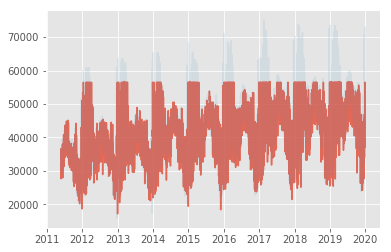

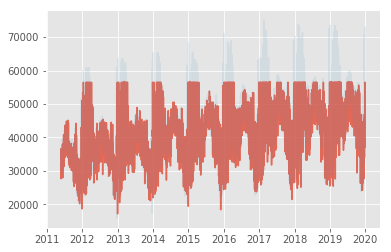

In [184]:
pred = knn_pipe.predict(x_test_real)
plt.plot(y_test_real.index, pred, alpha=0.8)
plt.plot(y_test_real, alpha=0.1)
plt.show()

#a = revtransdiff(pred, y_test_real)
plt.plot(y_test_real.index, pred, alpha=0.8)
plt.plot(y_test_real.index, y_test_real, alpha=0.1)
plt.show()

### 3.2 log diff values

In [185]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Create a k-NN pipeline
knn_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor(n_neighbors=5))
])

# Fit estimator
knn_pipe.fit(x_train_logdiff, y_train_logdiff)

# Evaluate on test set
print('Accuracy: {:.3f}'.format(knn_pipe.score(x_test_logdiff, y_test_logdiff)))

Accuracy: 0.548


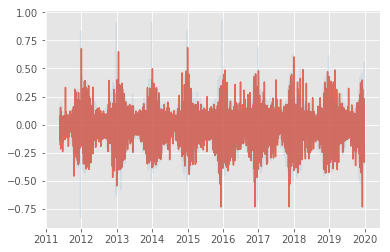

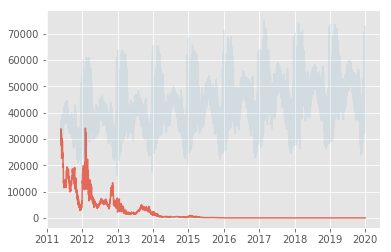

In [186]:
pred = knn_pipe.predict(x_test_logdiff)

plt.plot(y_test_real[1:].index, pred, alpha=0.8)
plt.plot(y_test_real[1:].index, y_test_logdiff, alpha=0.1)
plt.show()

a = revtransdiff(pred, y_test_real)
plt.plot(y_test_real.index, a, alpha=0.8)
plt.plot(y_test_real.index, y_test_real, alpha=0.1)
plt.show()

### 3.3 diff values X and Y

# multiples of 7 : 1
# loops to execute : [1]
# of days to shift : 7
                  7
date               
1984-01-09  15318.0
1984-01-10  11596.0
1984-01-11  12820.0
1984-01-12  11230.0
1984-01-13  10095.0
Line nb of train/test sets : 9999
0.8053120036879183


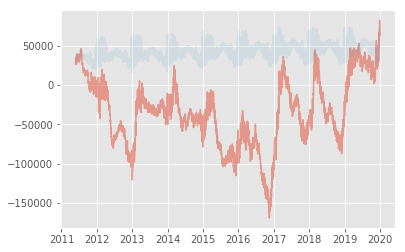

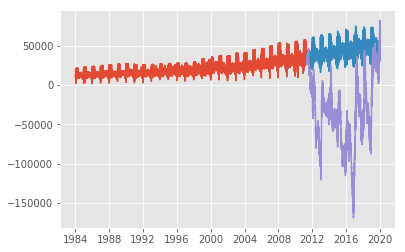

In [187]:
# DIFF X AND Y

#features_col = ['year', 'month_nb']
features_col = []
x_logdiff, y_logdiff, x_real, y_real, x_train_logdiff, y_train_logdiff, x_test_logdiff, y_test_logdiff, x_train_real, y_train_real, x_test_real, y_test_real = createsetsmultifeaturesMSadd1(data_ofac_cleaned, 'GVA', 8, lg1='n', adcol=features_col)

knn_pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('knn', KNeighborsRegressor(n_neighbors=2))
        ])

x_train_log = np.diff(x_train_real.reshape(-1)).reshape(-1, 1)
x_test_log = np.diff(x_test_real.reshape(-1)).reshape(-1, 1)
y_train_log = np.diff(y_train_real)
y_test_log = np.diff(y_test_real)

knn_pipe.fit(x_train_log, y_train_log)
print(knn_pipe.score(x_train_log, y_train_log))

a = knn_pipe.predict(x_test_log)
b = np.cumsum(np.concatenate(([y_test_real[0]], a)))

plt.plot(y_test_real.index, b, alpha=0.5)
plt.plot(y_test_real, alpha=0.1)
plt.show()

plt.plot(y_train_real.index, y_train_real)
plt.plot(y_test_real.index, y_test_real)
plt.plot(y_test_real.index, b)
plt.show()

### 3.4 diff values y only

# multiples of 7 : 1
# loops to execute : [1]
# of days to shift : 7
                  7
date               
1984-01-09  15318.0
1984-01-10  11596.0
1984-01-11  12820.0
1984-01-12  11230.0
1984-01-13  10095.0
Line nb of train/test sets : 9999
0.5669013436584158


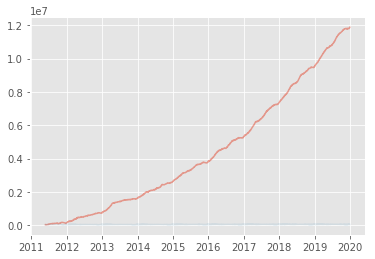

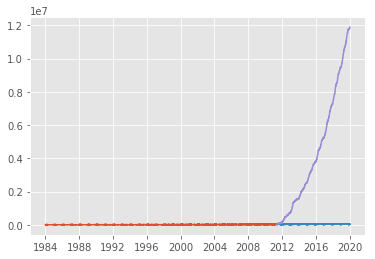

In [188]:
#DIFF y only

#features_col = ['year', 'month_nb']
features_col = []
x_logdiff, y_logdiff, x_real, y_real, x_train_logdiff, y_train_logdiff, x_test_logdiff, y_test_logdiff, x_train_real, y_train_real, x_test_real, y_test_real = createsetsmultifeaturesMSadd1(data_ofac_cleaned, 'GVA', 8, lg1='n', adcol=features_col)

knn_pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('knn', KNeighborsRegressor(n_neighbors=2))
        ])

y_train_log = np.diff(y_train_real)
y_test_log = np.diff(y_test_real)

knn_pipe.fit(x_train_real[1:], y_train_log)
print(knn_pipe.score(x_train_real[1:], y_train_log))
a = knn_pipe.predict(x_test_real[1:])
b = np.cumsum(np.concatenate(([y_test_real[0]], a)))

plt.plot(y_test_real.index, b, alpha=0.5)
plt.plot(y_test_real, alpha=0.1)
plt.show()

plt.plot(y_train_real.index, y_train_real)
plt.plot(y_test_real.index, y_test_real)
plt.plot(y_test_real.index, b)
plt.show()

### 3.5 LOG values y only

# multiples of 7 : 1
# loops to execute : [1]
# of days to shift : 7
                  7
date               
1984-01-09  15318.0
1984-01-10  11596.0
1984-01-11  12820.0
1984-01-12  11230.0
1984-01-13  10095.0
Line nb of train/test sets : 9999
0.9211979539246149


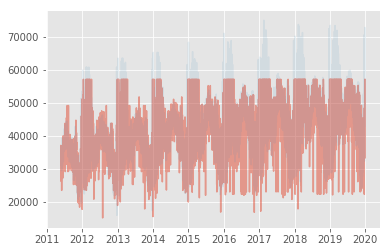

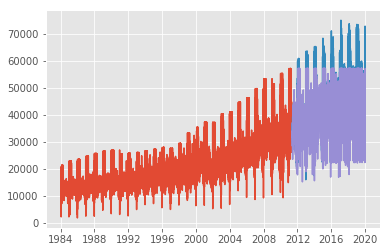

In [189]:
#3.5 LOG y only

#features_col = ['year', 'month_nb']
features_col = []
x_logdiff, y_logdiff, x_real, y_real, x_train_logdiff, y_train_logdiff, x_test_logdiff, y_test_logdiff, x_train_real, y_train_real, x_test_real, y_test_real = createsetsmultifeaturesMSadd1(data_ofac_cleaned, 'GVA', 8, lg1='n', adcol=features_col)

knn_pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('knn', KNeighborsRegressor(n_neighbors=2))
        ])

y_train_log = np.log(y_train_real)
y_test_log = np.log(y_test_real)

knn_pipe.fit(x_train_real, y_train_log)
print(knn_pipe.score(x_train_real, y_train_log))
a = knn_pipe.predict(x_test_real)
b = np.exp(a)

plt.plot(y_test_real.index, b, alpha=0.5)
plt.plot(y_test_real, alpha=0.1)
plt.show()

plt.plot(y_train_real.index, y_train_real)
plt.plot(y_test_real.index, y_test_real)
plt.plot(y_test_real.index, b)
plt.show()

In [190]:
data_ofac_cleaned.columns

Index(['ZRH', 'GVA', 'EAP', 'year', 'month', 'FirstDifferenceEAP',
       'FirstDifferenceGVA', 'FirstDifferenceZRH', 'LogTransformEAP',
       'LogTransformGVA',
       ...
       'xGVA22', 'xGVA23', 'xGVA24', 'xGVA25', 'xGVA26', 'xGVA27', 'xGVA28',
       'xGVA29', 'xGVA30', 'xGVA31'],
      dtype='object', length=105)

## 4. Using non-continuous day lags - different time lags

In [191]:
features_col = ['month_nb', 'year', 'date_jour_1', 'date_jour_2', 'date_jour_3',
       'date_jour_4', 'date_jour_5', 'date_jour_6', 'is_weekend_True',
       'season_spring', 'season_summer', 'season_winter', 'quarter_2',
       'quarter_3', 'quarter_4','GDP_diff', 'population_diff']

In [192]:
# Checking the variance of the features - the higher the better
data_ofac_cleaned[features_col].var()

month_nb               11.914217
year                  108.492077
date_jour_1             0.122489
date_jour_2             0.122381
date_jour_3             0.122489
date_jour_4             0.122435
date_jour_5             0.122489
date_jour_6             0.122435
is_weekend_True         0.204102
season_spring           0.188319
season_summer           0.188319
season_winter           0.187827
quarter_2               0.186953
quarter_3               0.188319
quarter_4               0.188319
GDP_diff           132642.592275
population_diff     48062.145152
dtype: float64

In [193]:
features_col = ['year', 'date_jour_1', 'date_jour_2', 'date_jour_3',
       'date_jour_4', 'date_jour_5', 'date_jour_6', 'is_weekend_True',
       'season_spring', 'season_summer', 'season_winter', 'quarter_2',
       'quarter_3', 'quarter_4','GDP_diff', 'population_diff']
x_logdiff, y_logdiff, x_real, y_real, x_train_logdiff, y_train_logdiff, x_test_logdiff, y_test_logdiff, x_train_real, y_train_real, x_test_real, y_test_real = createsetsmultifeaturesMSadd1(data_ofac_cleaned, 'GVA', 30, lg1='n', adcol=features_col)

# multiples of 7 : 4
# loops to execute : [1 2 3 4]
# of days to shift : 28
            year  date_jour_1  date_jour_2  date_jour_3  date_jour_4  \
date                                                                   
1984-01-30  1984            0            0            0            0   
1984-01-31  1984            1            0            0            0   
1984-02-01  1984            0            1            0            0   
1984-02-02  1984            0            0            1            0   
1984-02-03  1984            0            0            0            1   

            date_jour_5  date_jour_6  is_weekend_True  season_spring  \
date                                                                   
1984-01-30            0            0                0              0   
1984-01-31            0            0                0              0   
1984-02-01            0            0                0              0   
1984-02-02            0            0                0      

### real values

In [194]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Create a k-NN pipeline
knn_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor(n_neighbors=5))
])

# Fit estimator
knn_pipe.fit(x_train_real, y_train_real)

# Evaluate on test set
print('Accuracy: {:.3f}'.format(knn_pipe.score(x_test_real, y_test_real)))


Accuracy: -0.226


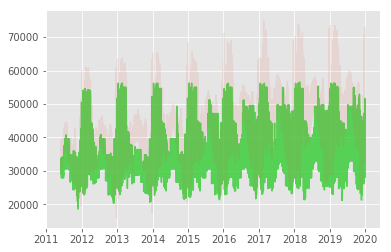

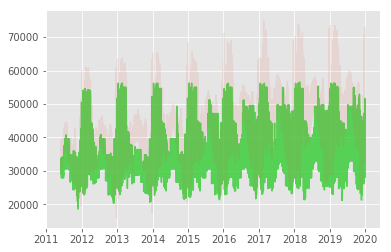

In [195]:
pred = knn_pipe.predict(x_test_real)
plt.plot(y_test_real.index, pred, alpha=0.8, c='limegreen')
plt.plot(y_test_real, alpha=0.1)
plt.show()

#a = revtransdiff(pred, y_test_real)
plt.plot(y_test_real.index, pred, alpha=0.8, c='limegreen')
plt.plot(y_test_real.index, y_test_real, alpha=0.1)
plt.show()

### log diff values

In [196]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Create a k-NN pipeline
knn_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor(n_neighbors=5))
])

# Fit estimator
knn_pipe.fit(x_train_logdiff, y_train_logdiff)

# Evaluate on test set
print('Accuracy: {:.3f}'.format(knn_pipe.score(x_test_logdiff, y_test_logdiff)))

Accuracy: 0.589


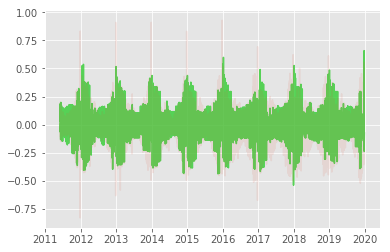

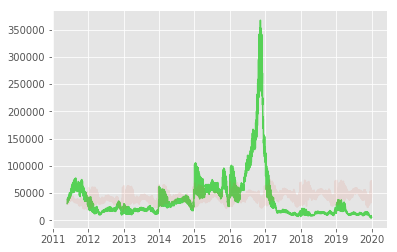

In [197]:
pred = knn_pipe.predict(x_test_logdiff)

plt.plot(y_test_real[1:].index, pred, alpha=0.8, color='limegreen')
plt.plot(y_test_real[1:].index, y_test_logdiff, alpha=0.1)
plt.show()

a = revtransdiff(pred, y_test_real)
plt.plot(y_test_real.index, a, alpha=0.8, color='limegreen')
plt.plot(y_test_real.index, y_test_real, alpha=0.1)
plt.show()

### 4.3 log diff values using standard scaler manually

In [198]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Create a k-NN pipeline
knn_pipe = Pipeline([
    #('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor(n_neighbors=5))
])

scaler = StandardScaler()
scaler.fit(x_train_logdiff.reshape(-1, 1))

x_train_logdiff_scaled = scaler.transform(x_train_logdiff)
y_train_logdiff_scaled = scaler.transform(y_train_logdiff.reshape(-1, 1))
x_test_logdiff_scaled = scaler.transform(x_test_logdiff)
y_test_logdiff_scaled = scaler.transform(y_test_logdiff.reshape(-1, 1)) 

# Fit estimator
knn_pipe.fit(x_train_logdiff_scaled, y_train_logdiff_scaled)

# Evaluate on test set
print('Accuracy: {:.3f}'.format(knn_pipe.score(x_test_logdiff_scaled, y_test_logdiff_scaled)))

Accuracy: 0.047


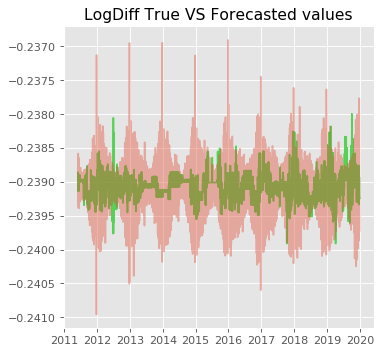

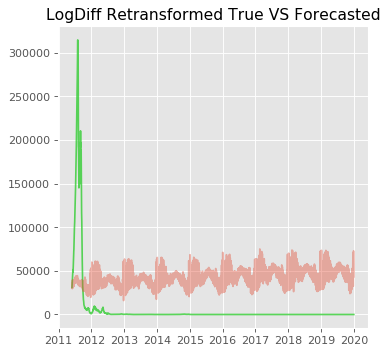

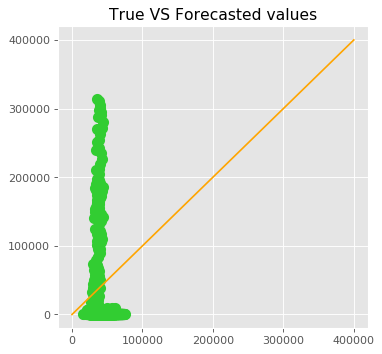

In [199]:
pred_s = knn_pipe.predict(x_test_logdiff_scaled)
pred = scaler.inverse_transform(pred_s)

plt.figure(figsize=(5,5), dpi=80)
plt.plot(y_test_real[1:].index, pred_s, alpha=0.8, c='limegreen')
plt.plot(y_test_real[1:].index, y_test_logdiff_scaled, alpha=0.4)
plt.title('LogDiff True VS Forecasted values', fontsize=14, fontweight=0, color='black')
plt.show()

plt.figure(figsize=(5,5), dpi=80)
a = revtransdiff(pred.reshape(-1), y_test_real)
plt.plot(y_test_real.index, a, alpha=0.8, c='limegreen')
plt.plot(y_test_real.index, y_test_real, alpha=0.4)
plt.title('LogDiff Retransformed True VS Forecasted', fontsize=14, fontweight=0, color='black')
plt.show()


# Plotting
plt.style.use('ggplot')
plt.figure(figsize=(5,5), dpi=80)

# scatter plot
plt.scatter(y_test_real, a, color='seagreen', linewidth=4, alpha=1)

# Add title & legend
plt.title('True VS Forecasted values', fontsize=14, fontweight=0, color='black')
plt.xticks(np.arange(0, 500000, 100000))
plt.yticks(np.arange(0, 500000, 100000))

# creating a straight line
xline = np.arange(0, 500000, 100000)
yline = np.arange(0, 500000, 100000)
plt.plot(xline, yline, '-r', c='limegreen')

plt.show()

### 4.4 log diff values using standard scaler manually AND pipe scaler

In [205]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Create a k-NN pipeline
knn_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor(n_neighbors=5))
])

scaler = StandardScaler()
scaler.fit(x_train_logdiff.reshape(-1, 1))

x_train_logdiff_scaled = scaler.transform(x_train_logdiff)
y_train_logdiff_scaled = scaler.transform(y_train_logdiff.reshape(-1, 1))
x_test_logdiff_scaled = scaler.transform(x_test_logdiff)
y_test_logdiff_scaled = scaler.transform(y_test_logdiff.reshape(-1, 1)) 

# Fit estimator
knn_pipe.fit(x_train_logdiff_scaled, y_train_logdiff_scaled)

# Evaluate on test set
print('Accuracy: {:.3f}'.format(knn_pipe.score(x_test_logdiff_scaled, y_test_logdiff_scaled)))

Accuracy: 0.589


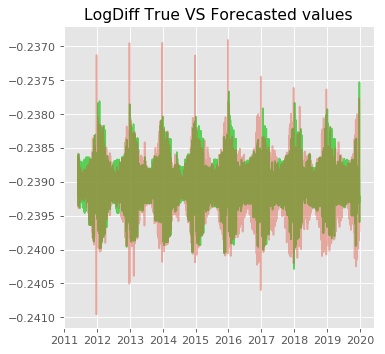

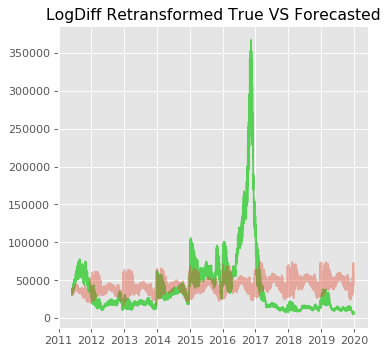

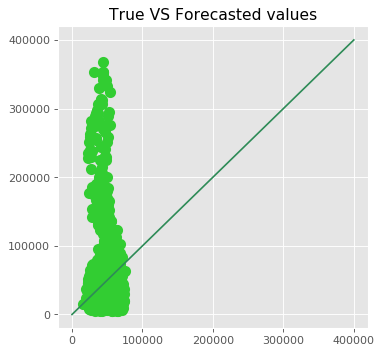

In [206]:
pred_s = knn_pipe.predict(x_test_logdiff_scaled)
pred = scaler.inverse_transform(pred_s)

plt.figure(figsize=(5,5), dpi=80)
plt.plot(y_test_real[1:].index, pred_s, alpha=0.8, c='limegreen')
plt.plot(y_test_real[1:].index, y_test_logdiff_scaled, alpha=0.4)
plt.title('LogDiff True VS Forecasted values', fontsize=14, fontweight=0, color='black')
plt.show()

plt.figure(figsize=(5,5), dpi=80)
a = revtransdiff(pred.reshape(-1), y_test_real)
plt.plot(y_test_real.index, a, alpha=0.8, c='limegreen')
plt.plot(y_test_real.index, y_test_real, alpha=0.4)
plt.title('LogDiff Retransformed True VS Forecasted', fontsize=14, fontweight=0, color='black')
plt.show()


# Plotting
plt.style.use('ggplot')
plt.figure(figsize=(5,5), dpi=80)

# scatter plot
plt.scatter(y_test_real, a, color='seagreen', linewidth=4, alpha=1)

# Add title & legend
plt.title('True VS Forecasted values', fontsize=14, fontweight=0, color='black')
plt.xticks(np.arange(0, 500000, 100000))
plt.yticks(np.arange(0, 500000, 100000))

# creating a straight line
xline = np.arange(0, 500000, 100000)
yline = np.arange(0, 500000, 100000)
plt.plot(xline, yline, '-r', c='limegreen')

plt.show()

### 4.5 log diff values => tuning

In [202]:
#Pipeline object - 

from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import numpy as np

# Generate a set of k values
k_values = np.r_[1, np.arange(5, 101, step=15)]
p_values = [1, 2]
algo_values = ['ball_tree', 'kd_tree', 'brute', 'auto']
weights_values=['uniform', 'distance']
gs_results = []

for k in k_values:
    for pval in p_values:
        for algo in algo_values:
            for weig in weights_values:
                knn_pipe = Pipeline([
                    ('scaler', StandardScaler()),
                    ('knn', KNeighborsRegressor(n_neighbors=k,
                                   weights=weig,
                                   algorithm=algo,
                                   p=pval,
                                   n_jobs=-1))
                ])

                knn_pipe.fit(x_train_logdiff, y_train_logdiff)

                gs_results.append({
                    'k':k,
                    'p':pval,
                    'algorithm':algo,
                    'weights':weig,
                    'train_accuracy': knn_pipe.score(x_train_logdiff, y_train_logdiff),
                    'test_accuracy': knn_pipe.score(x_test_logdiff, y_test_logdiff)
                })
# Convert results to DataFrame
gs_results = pd.DataFrame(gs_results)
gs_results.sort_values(by='test_accuracy', ascending=False).head()

,algorithm,k,p,test_accuracy,train_accuracy,weights
35,kd_tree,20,1,0.637534,1.0,distance
33,ball_tree,20,1,0.637534,1.0,distance
37,brute,20,1,0.637534,1.0,distance
39,auto,20,1,0.637534,1.0,distance
55,auto,35,1,0.633771,1.0,distance


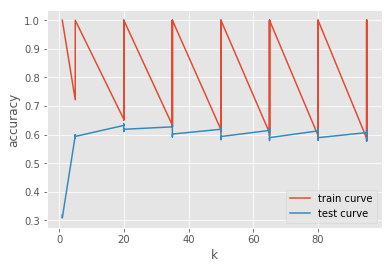

In [203]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot the validation curves
plt.plot(gs_results['k'], gs_results['train_accuracy'], label='train curve')
plt.plot(gs_results['k'], gs_results['test_accuracy'], label='test curve')
plt.ylabel('accuracy')
plt.xlabel('k')
plt.legend()
plt.show()

- results completely different when using manual standard scaler and automatic
- why the spikes in the plots, the logdiff values seems much more stable
- generally, logdiff on x, y or both ? read the three versions...